# Module 4: Regime-based Simulations and Multi-Period Portfolio Models

In this module, we will introduce the concept of economic and market regimes, demonstrate the significance of regime identification, evaluate the performance of regime identification methods

## Table of Contents:
&nbsp;&nbsp;1. [Introduction to Economic Regimes](#1)

&nbsp;&nbsp;2. [Identification of Regimes: the Trend-Filtering Algorithm](#2)   

&nbsp;&nbsp;3. [A Regime-based Single Period Model](#3)   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 [Regime Identification: Parameter Estimation](#3.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Scenario Simulation](#3.2)


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Single-period Portfolio Model](#3.3)

&nbsp;&nbsp;4. [Application: Scenario-based Analysis of University Endowment](#4) 


## 1. Introduction to Economic Regimes <a class="anchor" id="1"></a>

A regime is a period of time in which the characteristics of market performance and related economic activity are reasonably stable. 

For better analysis of the market, we would like to catagorize historical periods into a small number of regimes and evaluate each regime separately.

Let us plot the historical performance of the US stock market index (S&P 500) with regimes that we have determined. You will learn how to determine the regimes later in this chapter, so hang tight with us.

In [100]:
#import all the necessary packages
import numpy as np
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
sns.set()
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import regime_code as rg

#%load_ext autoreload
#%autoreload 2

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [26]:
asset_data = pd.read_csv('Assets_7.csv', index_col=0, header=0,parse_dates=[0])
asset_data.tail()

,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
2018-09-01,136.470,8028.0670,813.55680,1988.9650,7450.320,2751.3500,2844.2000,1761.3730,-1.22%,1,1,1
2018-10-01,136.910,8110.1000,805.02340,2003.8730,7208.820,2917.3450,2831.6360,1764.5910,0.38%,1,1,1
2018-11-01,140.157,8102.6736,807.85921,2018.4731,7447.212,2864.1230,2846.6581,1767.4145,-0.90%,1,1,1
2018-12-01,142.816,8115.2286,807.63156,2033.4364,7520.306,2893.2488,2854.3688,1770.3804,0.61%,1,1,1
2019-01-01,145.475,8127.7836,807.40391,2048.3997,7593.400,2922.3746,2862.0795,1773.3463,0.76%,1,1,1


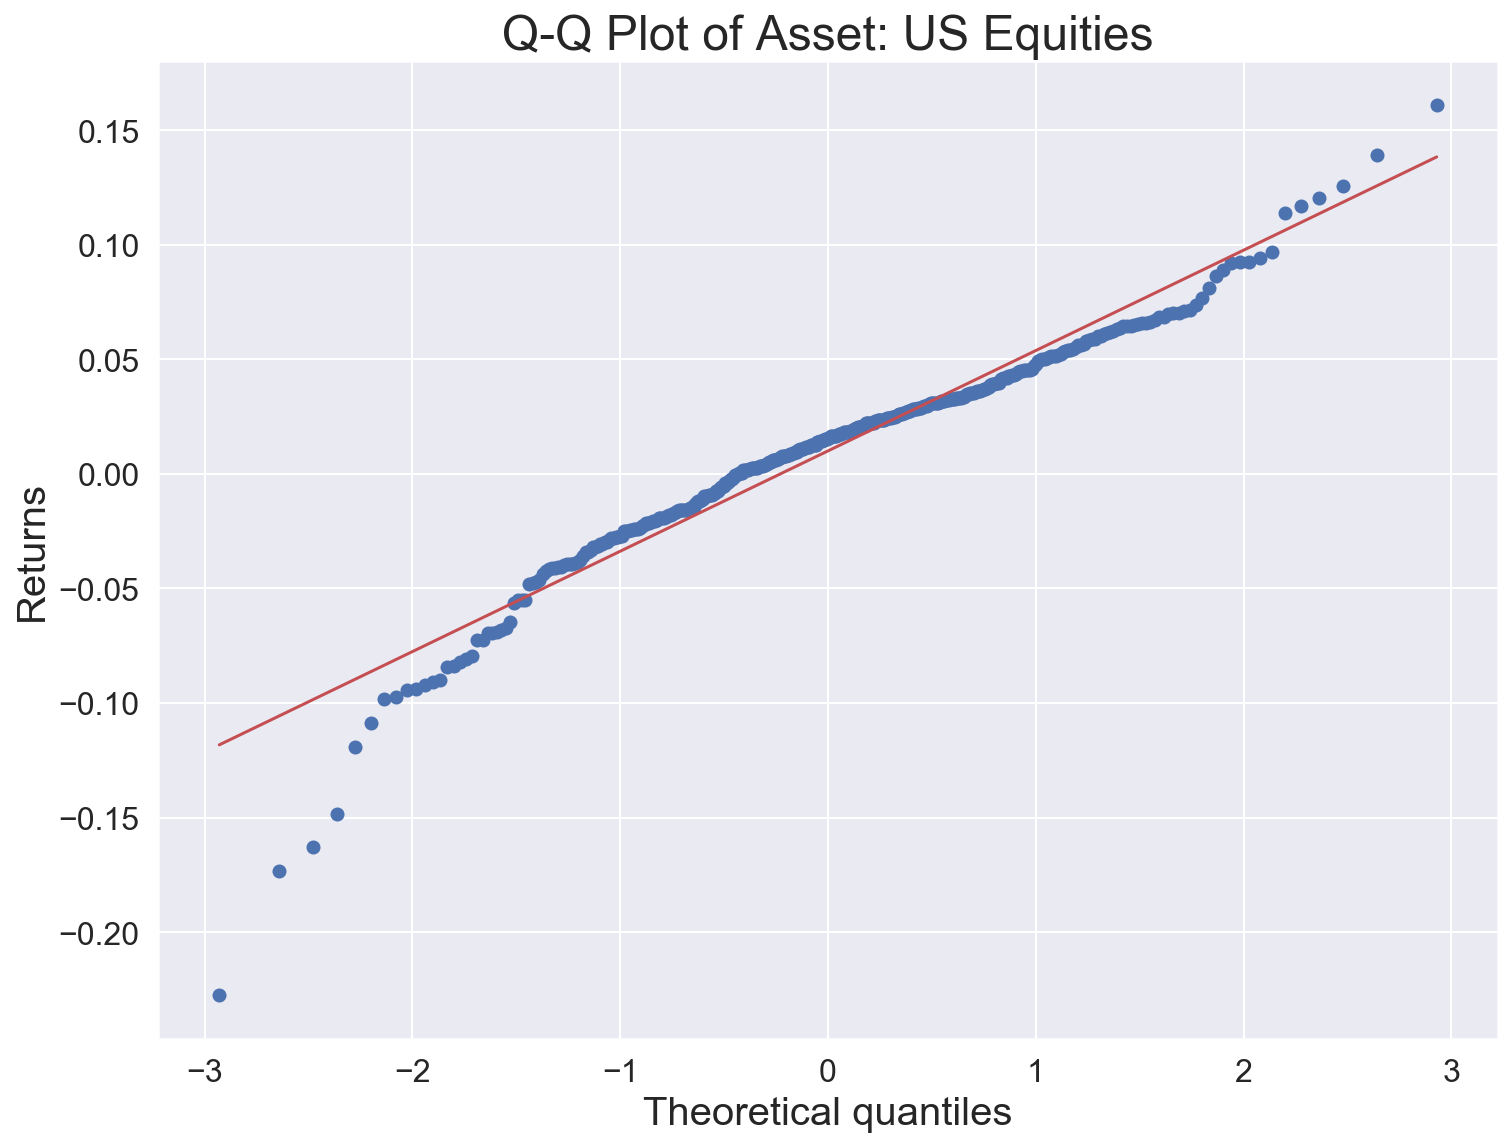

In [50]:
asset_index = [0,1,2,3,4,5,6,7]
ret, ret_g, ret_c = rg.regime_return(asset_data, asset_index, 'Regime-5')

rg.Q_Q_plot(asset_data, 0, ret)

Index(['US Equities', 'World Equities', 'US Treasuries', 'High Yield',
       'Real Estate', 'Commodities', 'Corp Bonds', 'T-bill', 'TIPS',
       'Regime-5', 'Regime-7', 'Regime-9'],
      dtype='object')


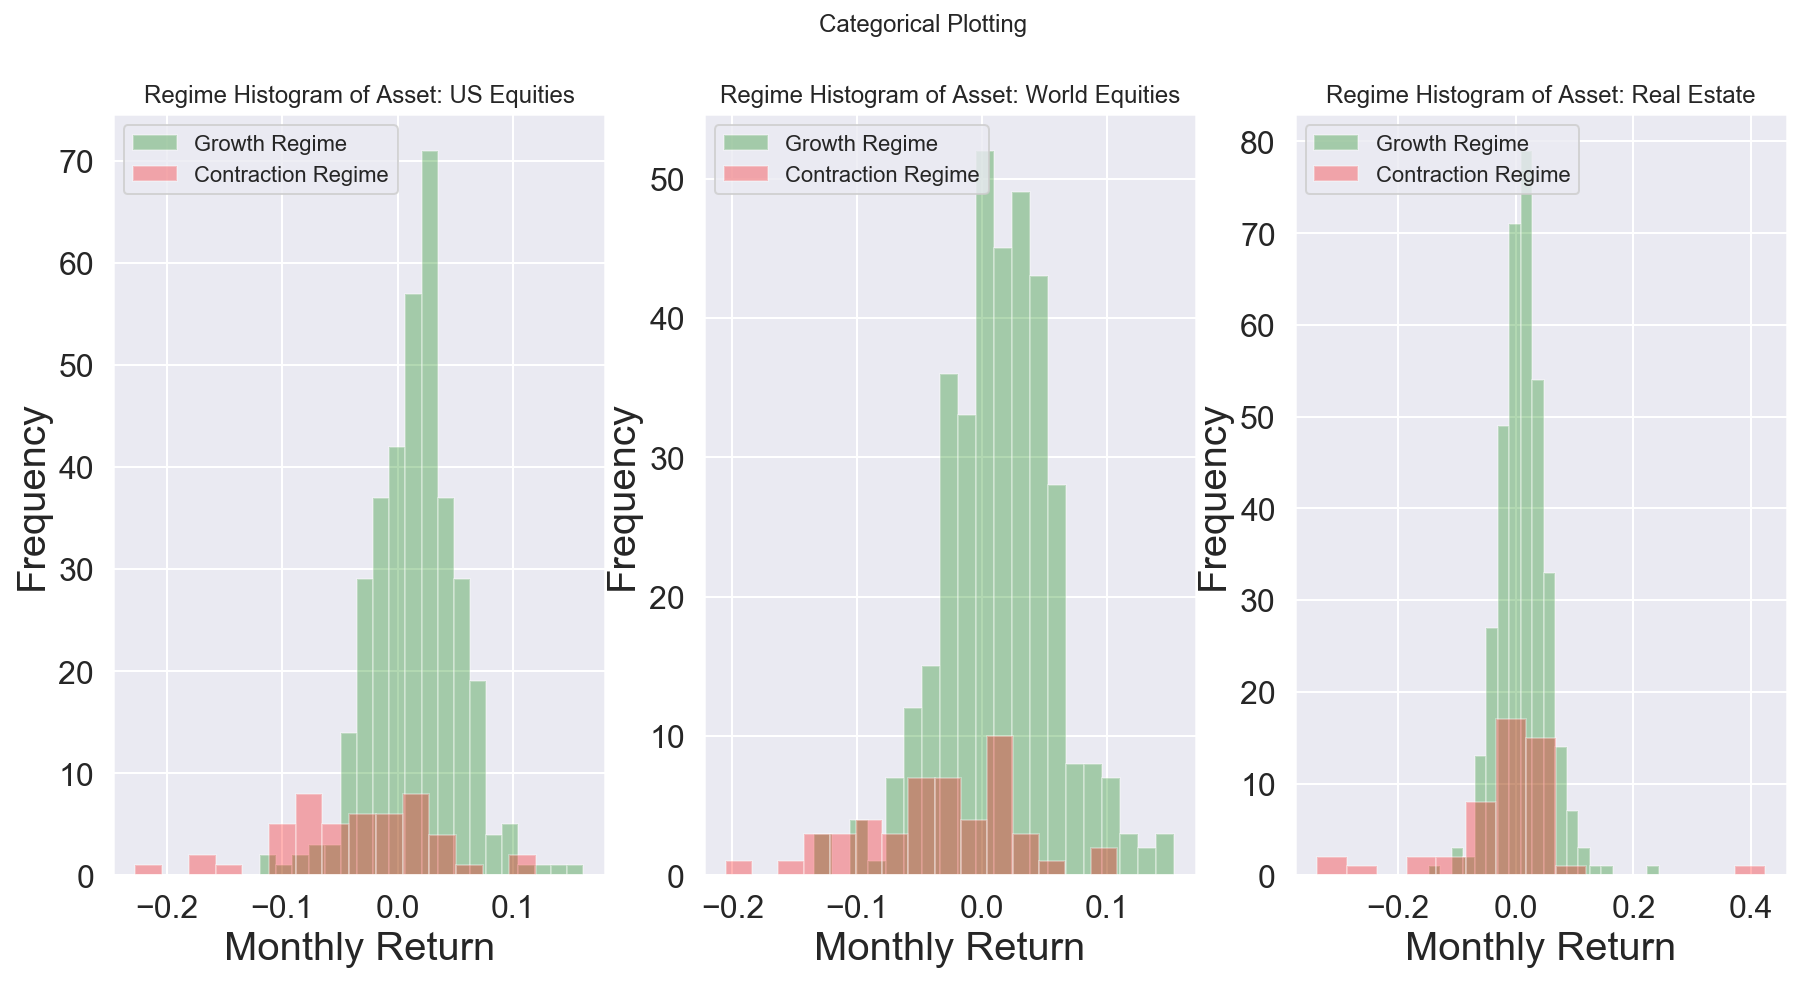

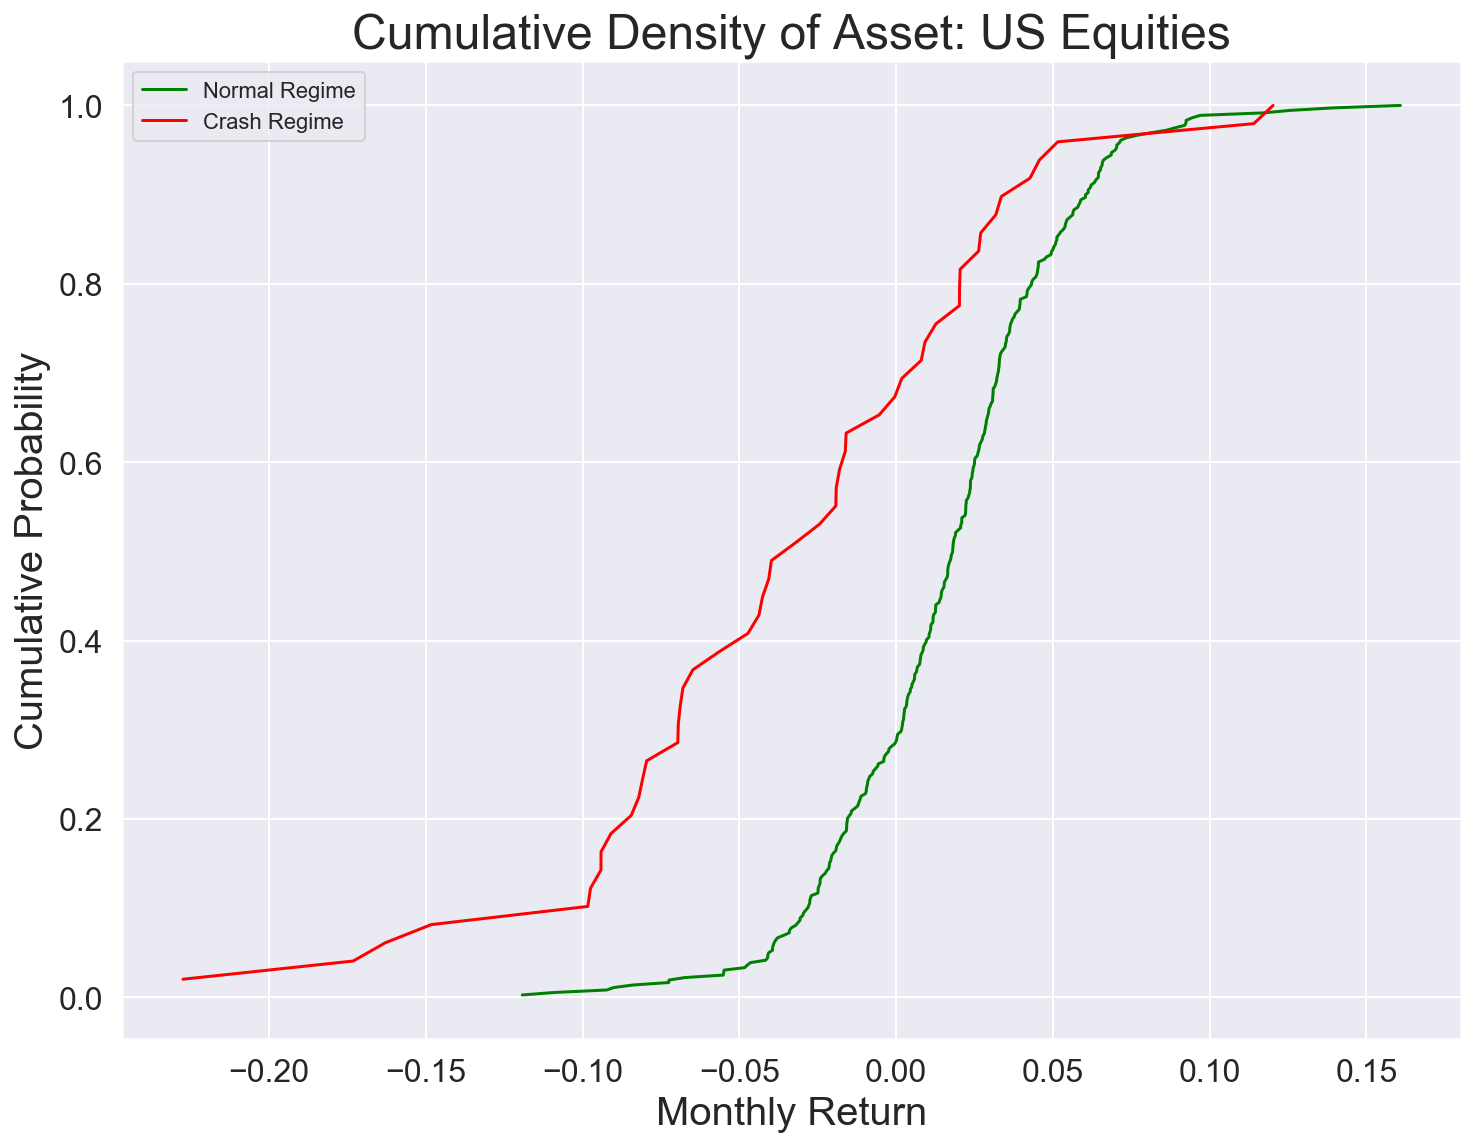

In [51]:
# Im not that interested in Tbill, treasury, or commodity prices, so let's focus on Equities and Real estate
print(asset_data.columns)

plt.figure(figsize=(15,7))
plt.suptitle('Categorical Plotting')
plt.subplot(131)
useq = rg.regime_hist(asset_data, 0, 'Regime-5')
plt.subplot(132)
weq = rg.regime_hist(asset_data, 1, 'Regime-5')
plt.subplot(133)
real = rg.regime_hist(asset_data, 4,'Regime-5')
plt.show()

rg.regime_plot(asset_data, 0,'Regime-5')

# following are other asset classes, but I'm not interested
#plt.figure(figsize=(15,7))
#plt.subplot(131)
#hy = rg.regime_hist(asset_data, 3, 'Regime-5')
#plt.subplot(132)
#bond = rg.regime_hist(asset_data, 6, 'Regime-5')
#plt.subplot(133)
#commod = rg.regime_hist(asset_data, 5, 'Regime-5')

We can observe that the monthly return distribution of World Equities is very different under growth regime or contraction regime. 

Now it's your turn to try more assets and compare their performance.

## 2. Identification of Regimes <a class="anchor" id="2"></a>

A regime analysis is significant in asset allocation and asset-liability management for long-term investors because of the contagion and related effects during crash periods: the correlation between risky assets and volatility will greatly increase during the crash periods, thus creating severe difficulty in risk management and protecting investor capital with traditional portfolio models.


Many existing methods are based on econometric models which assume a fixed structural model. However, financial return or macroeconomic data tends to be noisy and affected by myriad of factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), trend-filtering, is non-parametric, data-driven and model-free. The algorithm was first introduced by Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [2]:
# Import Data
SP500_data = pd.read_csv('SP500_updated.csv',index_col=0, header=0,parse_dates=[0])
SP500_data.tail()

,Open,High,Low,Close,adj_close,Volume,chg
Date,,,,,,,
2019-10-01,2983.689941,3050.100098,2855.939941,3037.560059,3037.560059,7.756455e+10,2.043177
2019-11-01,3050.719971,3154.260010,3050.719971,3140.979980,3140.979980,7.217992e+10,3.404704
2019-12-01,3143.850098,3247.929932,3070.330078,3230.780029,3230.780029,7.205400e+10,2.858982
2020-01-01,3244.669922,3337.770020,3214.639893,3225.520020,3225.520020,7.710442e+10,-0.162809
2020-02-01,3235.659912,3385.090088,3235.659912,3380.159912,3380.159912,3.750354e+10,4.794262


In the trend-filtering algorithm, we manage to find some ‘fitted’ time series that serves as the signal of the trend. This new time series can be obtained by solving the following optimization problem:

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

where

\begin{equation*} 
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
\end{equation*}

Let's take a look at our $\beta$ values versus the original SP500 total returns:

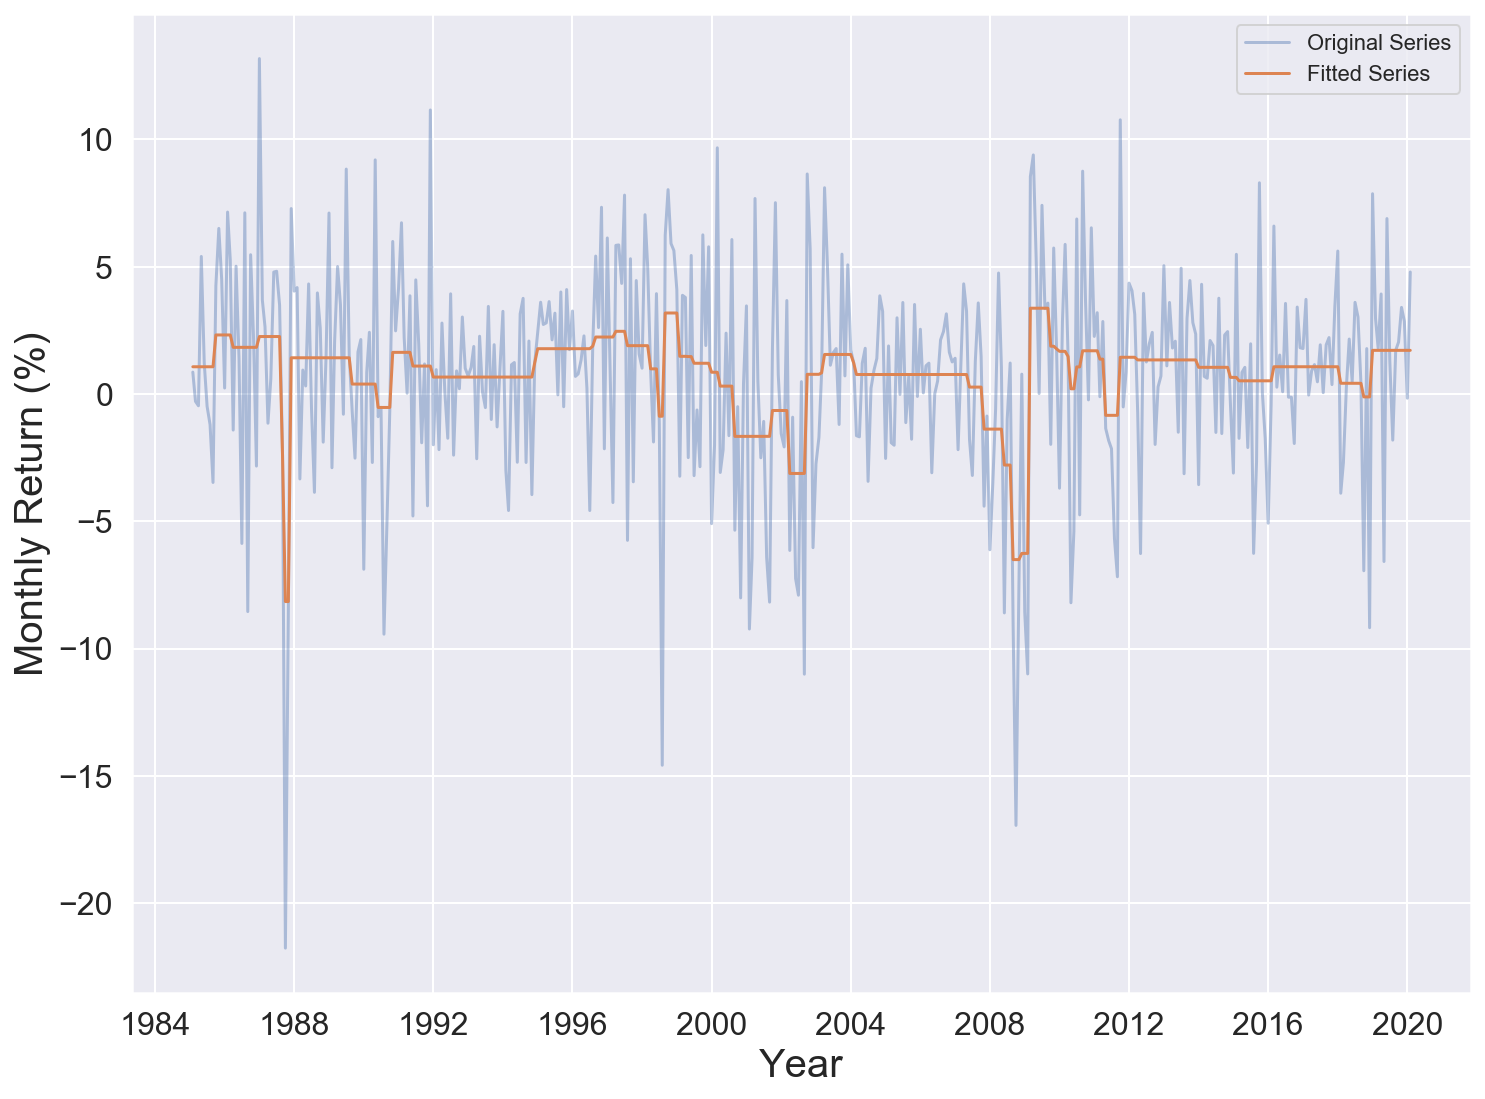

<Figure size 1080x360 with 0 Axes>

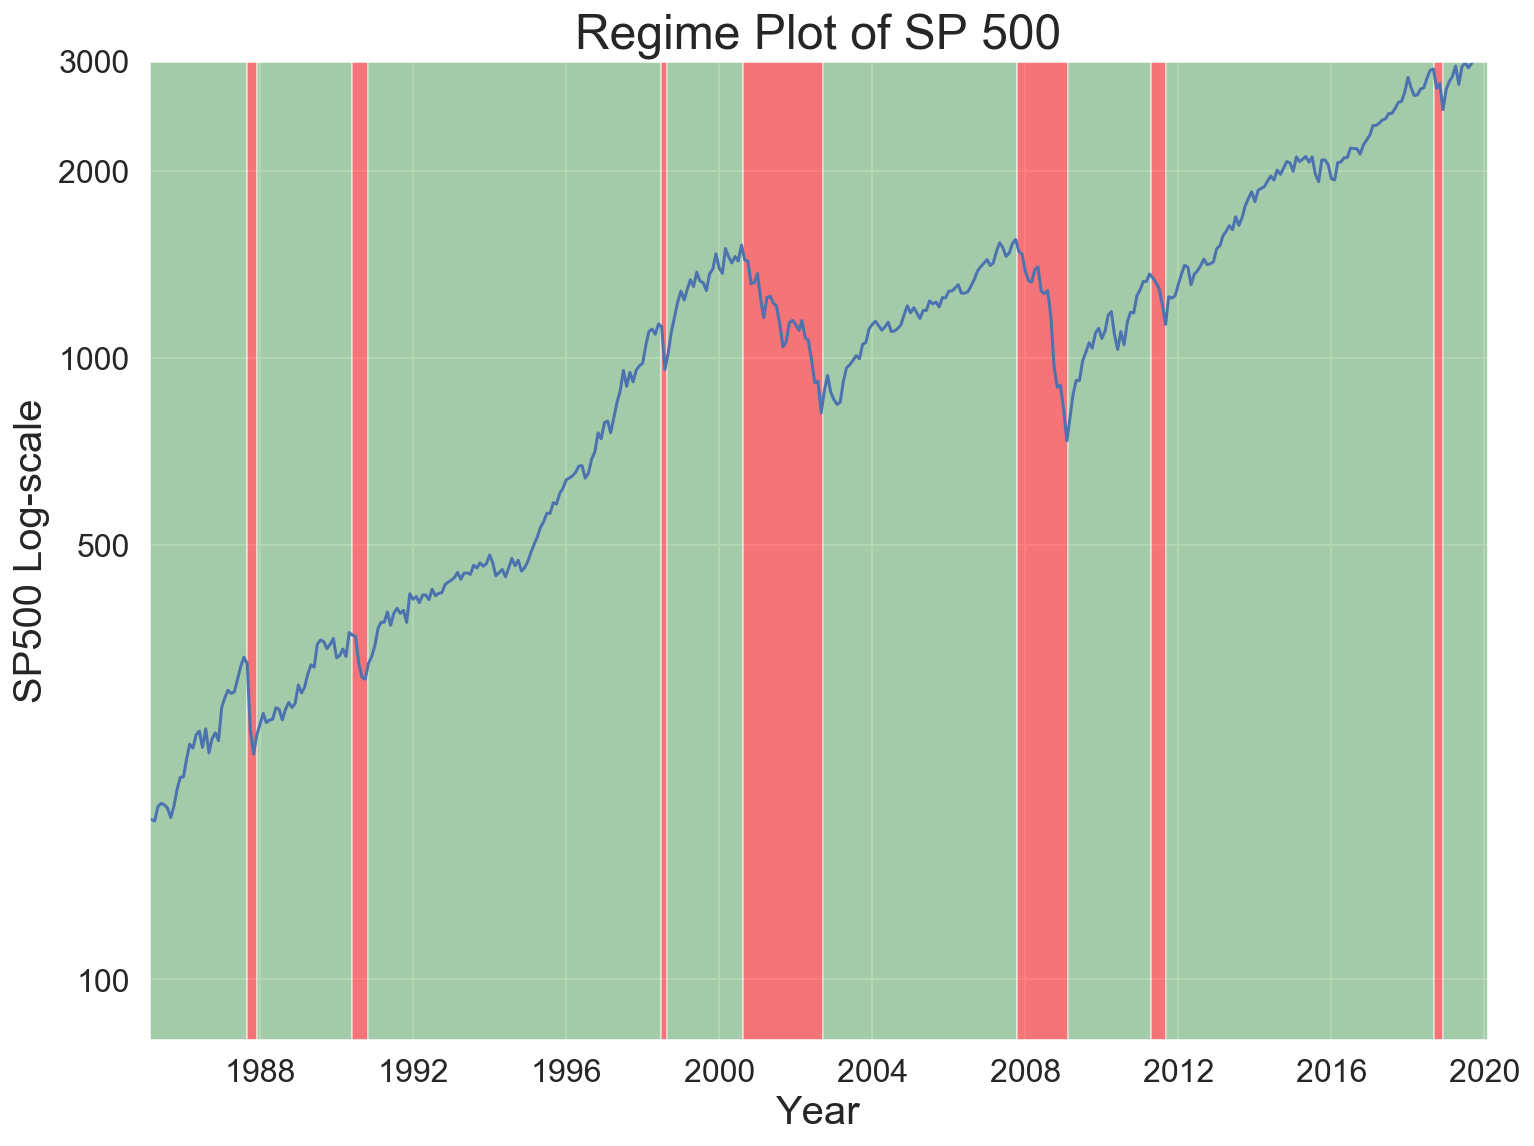

In [35]:
# Smaller lambda value means filter is more sensitive; lambda = 16 recognizes no regime change since after 2011
# If lambda = 14, then filter recognizes regime chagne at end of 2018

betas = rg.filter_plot(SP500_data, lambda_value=14,regime_num=6, TR_num=4)
plt.figure(figsize=(15,5))
rg.plot_regime_color(SP500_data, lambda_value=14,regime_num=6, TR_num=4)

In [84]:
switches=rg.regime_switch(betas)
print('Indexes of regime changes', switches)
periods = SP500_data.index[switches[1:-1]]
periods

# This works pretty well on monthly data, but it would be nice to see it work on weekly or daily data
# so that I could possibly make money by acting on it

Indexes of regime changes [0, 31, 34, 64, 69, 161, 163, 187, 212, 273, 289, 315, 320, 404, 407, 421]


DatetimeIndex(['1987-09-01', '1987-12-01', '1990-06-01', '1990-11-01',
               '1998-07-01', '1998-09-01', '2000-09-01', '2002-10-01',
               '2007-11-01', '2009-03-01', '2011-05-01', '2011-10-01',
               '2018-10-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

array([-7., -6., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

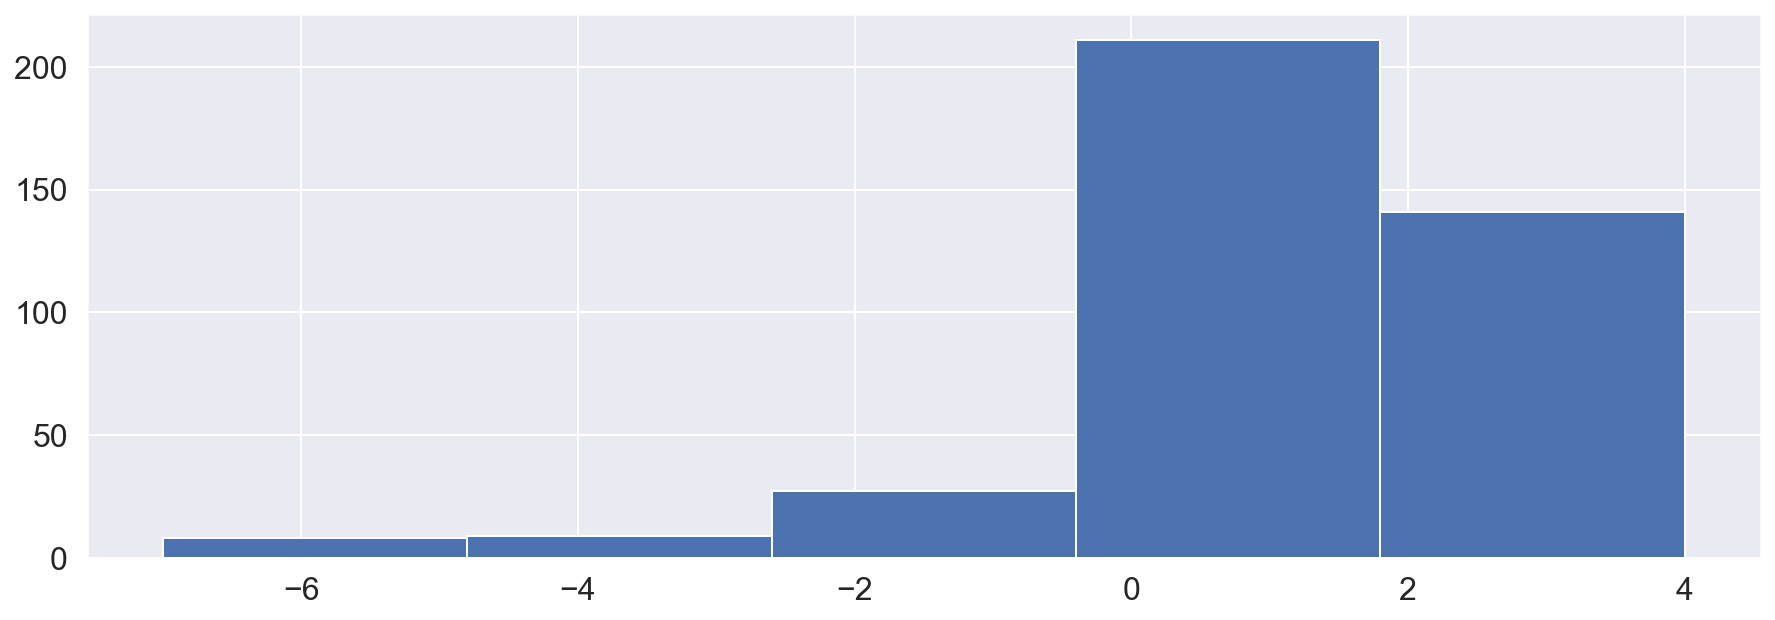

In [126]:
plt.figure(figsize=(15,5))
plt.hist(np.round_(betas.values, decimals=0),bins=5)
np.unique(np.round_(betas.values, decimals=0))

### Trying with Weekly Data (Monday prices) to do trend filtering

In [86]:
# Import Data
SP500_data_week = pd.read_csv('SP_500_weekly.csv', index_col=0, header=0, parse_dates=[0])
SP500_data_week.tail()

,Open,High,Low,Close,adj_close,Volume,chg
Date,,,,,,,
2020-01-13,3271.129883,3329.879883,3268.429932,3329.620117,3329.620117,18071600000,1.97
2020-01-20,3321.030029,3337.770020,3281.530029,3295.469971,3295.469971,15197180000,-1.03
2020-01-27,3247.159912,3293.469971,3214.679932,3225.520020,3225.520020,19249400000,-2.12
2020-02-03,3235.659912,3347.959961,3235.659912,3327.709961,3327.709961,19469980000,3.17
2020-02-10,3318.280029,3385.090088,3317.770020,3373.939941,3373.939941,14635520000,1.39


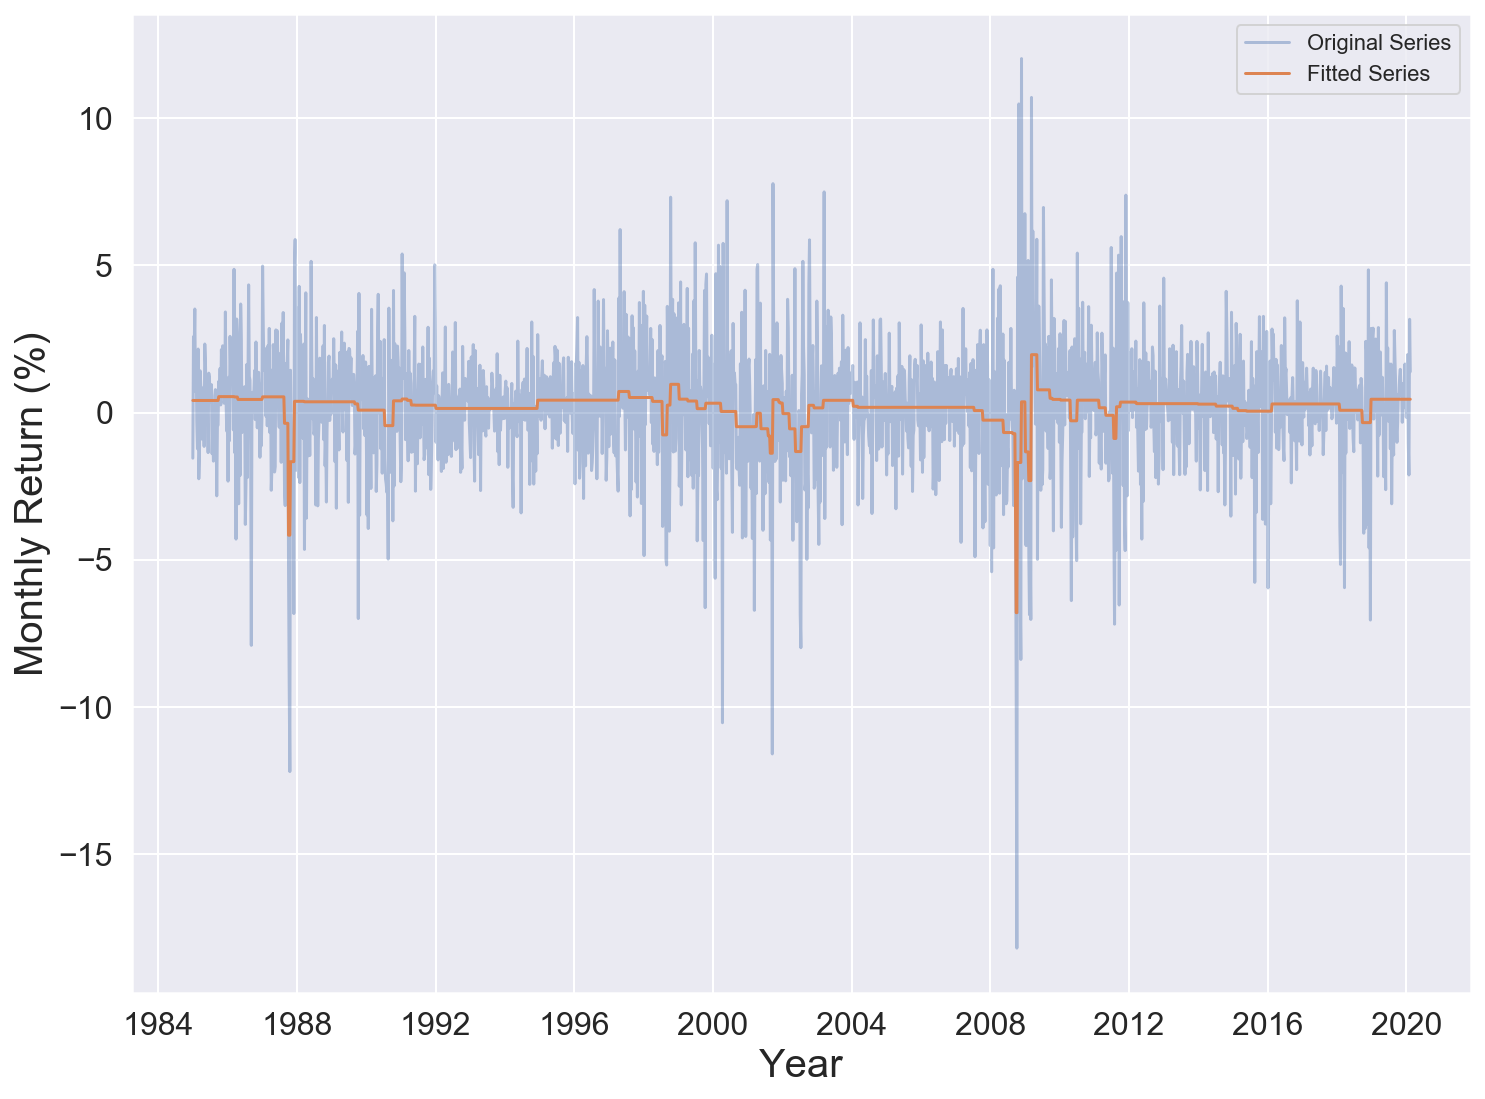

<Figure size 1080x360 with 0 Axes>

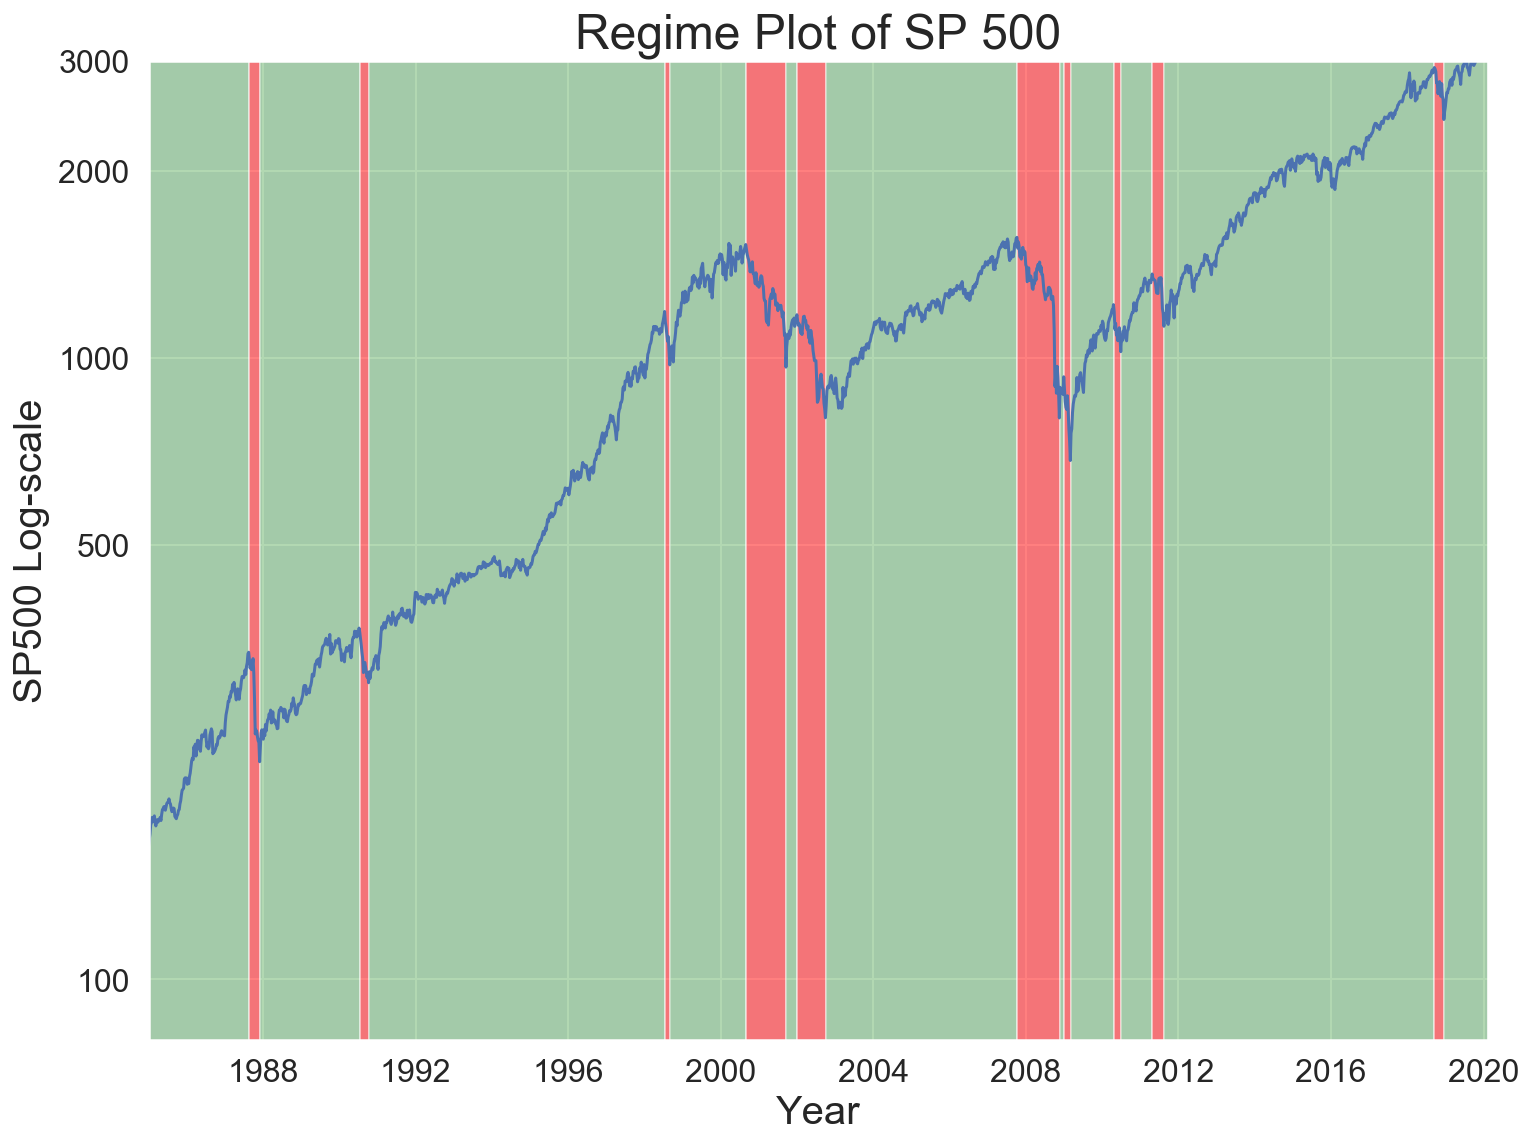

In [101]:
betas_week = rg.filter_plot(SP500_data_week, lambda_value=14, regime_num=6, TR_num=4)
plt.figure(figsize=(15,5))
rg.plot_regime_color(SP500_data_week, lambda_value=14, regime_num=6, TR_num=4)

In [91]:
switches_week=rg.regime_switch(betas_week)
print('Indexes of regime changes', switches_week)
periods_week = SP500_data_week.index[switches_week[1:-1]]
periods_week

Indexes of regime changes [0, 138, 153, 289, 302, 707, 714, 818, 873, 888, 927, 1189, 1247, 1253, 1262, 1321, 1331, 1374, 1390, 1760, 1773, 1833]


DatetimeIndex(['1987-08-24', '1987-12-07', '1990-07-16', '1990-10-15',
               '1998-07-20', '1998-09-07', '2000-09-04', '2001-09-24',
               '2002-01-07', '2002-10-07', '2007-10-15', '2008-11-24',
               '2009-01-05', '2009-03-09', '2010-04-26', '2010-07-05',
               '2011-05-02', '2011-08-22', '2018-09-24', '2018-12-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [98]:
SP500_data_week['adj_close'].tail().max()

3373.9399409999996

## Let's try various levels of lambda

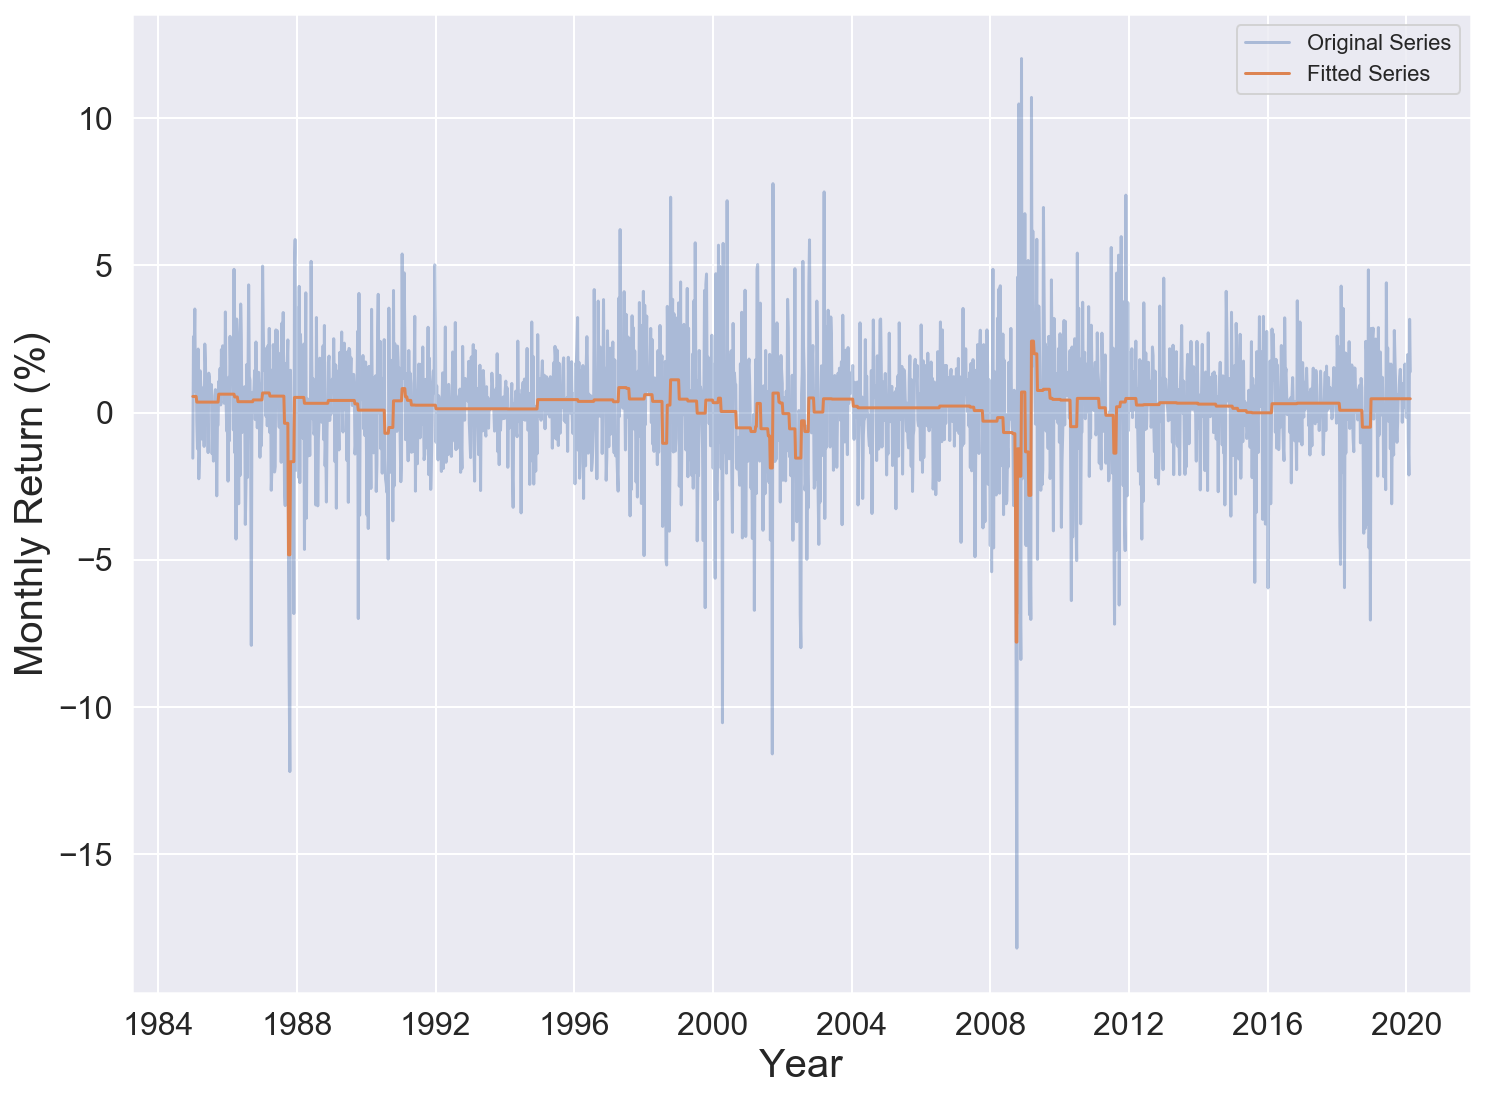

<Figure size 1080x360 with 0 Axes>

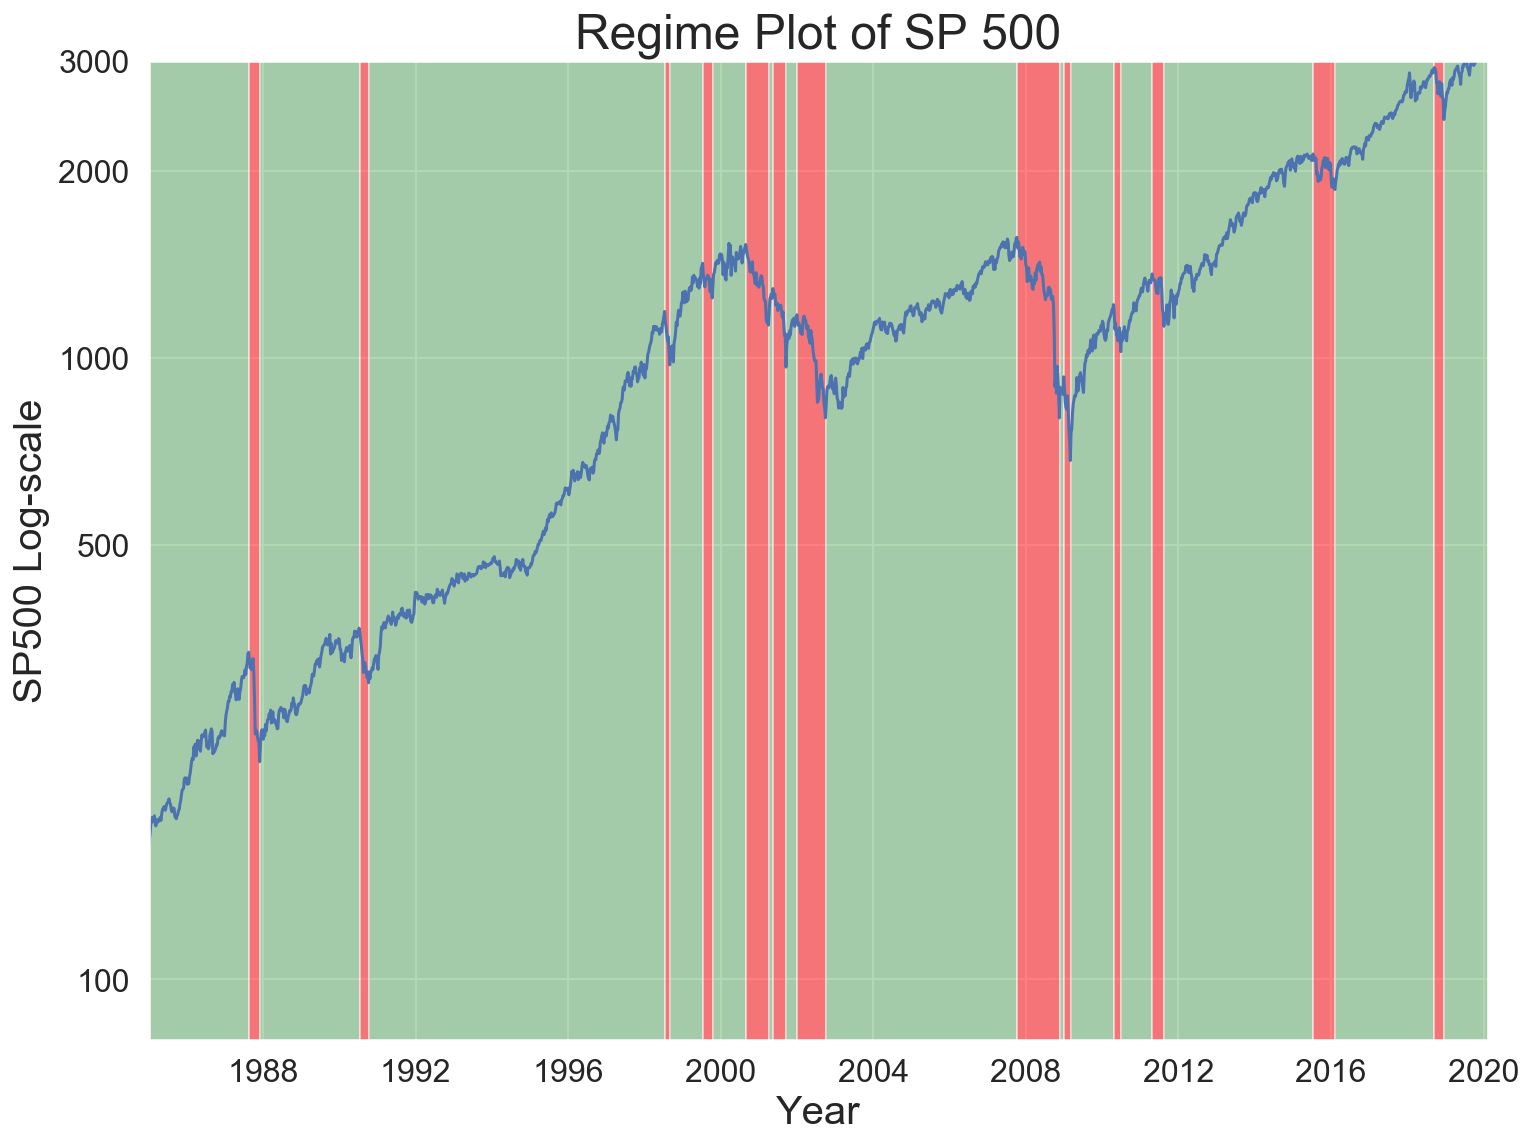

Indexes of regime changes [0, 138, 153, 289, 302, 707, 714, 759, 772, 818, 849, 855, 873, 888, 927, 1189, 1247, 1253, 1262, 1321, 1331, 1374, 1390, 1594, 1624, 1760, 1773, 1833]


DatetimeIndex(['1987-08-24', '1987-12-07', '1990-07-16', '1990-10-15',
               '1998-07-20', '1998-09-07', '1999-07-19', '1999-10-18',
               '2000-09-04', '2001-04-09', '2001-05-21', '2001-09-24',
               '2002-01-07', '2002-10-07', '2007-10-15', '2008-11-24',
               '2009-01-05', '2009-03-09', '2010-04-26', '2010-07-05',
               '2011-05-02', '2011-08-22', '2015-07-20', '2016-02-15',
               '2018-09-24', '2018-12-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [93]:
betas_week = rg.filter_plot(SP500_data_week, lambda_value=12, regime_num=6, TR_num=4)
plt.figure(figsize=(15,5))
rg.plot_regime_color(SP500_data_week, lambda_value=12, regime_num=6, TR_num=4)
switches_week=rg.regime_switch(betas_week)
print('Indexes of regime changes', switches_week)
periods_week = SP500_data_week.index[switches_week[1:-1]]
periods_week

# Lambda = 12 catches the flash crash in 2015; China slowdown fears

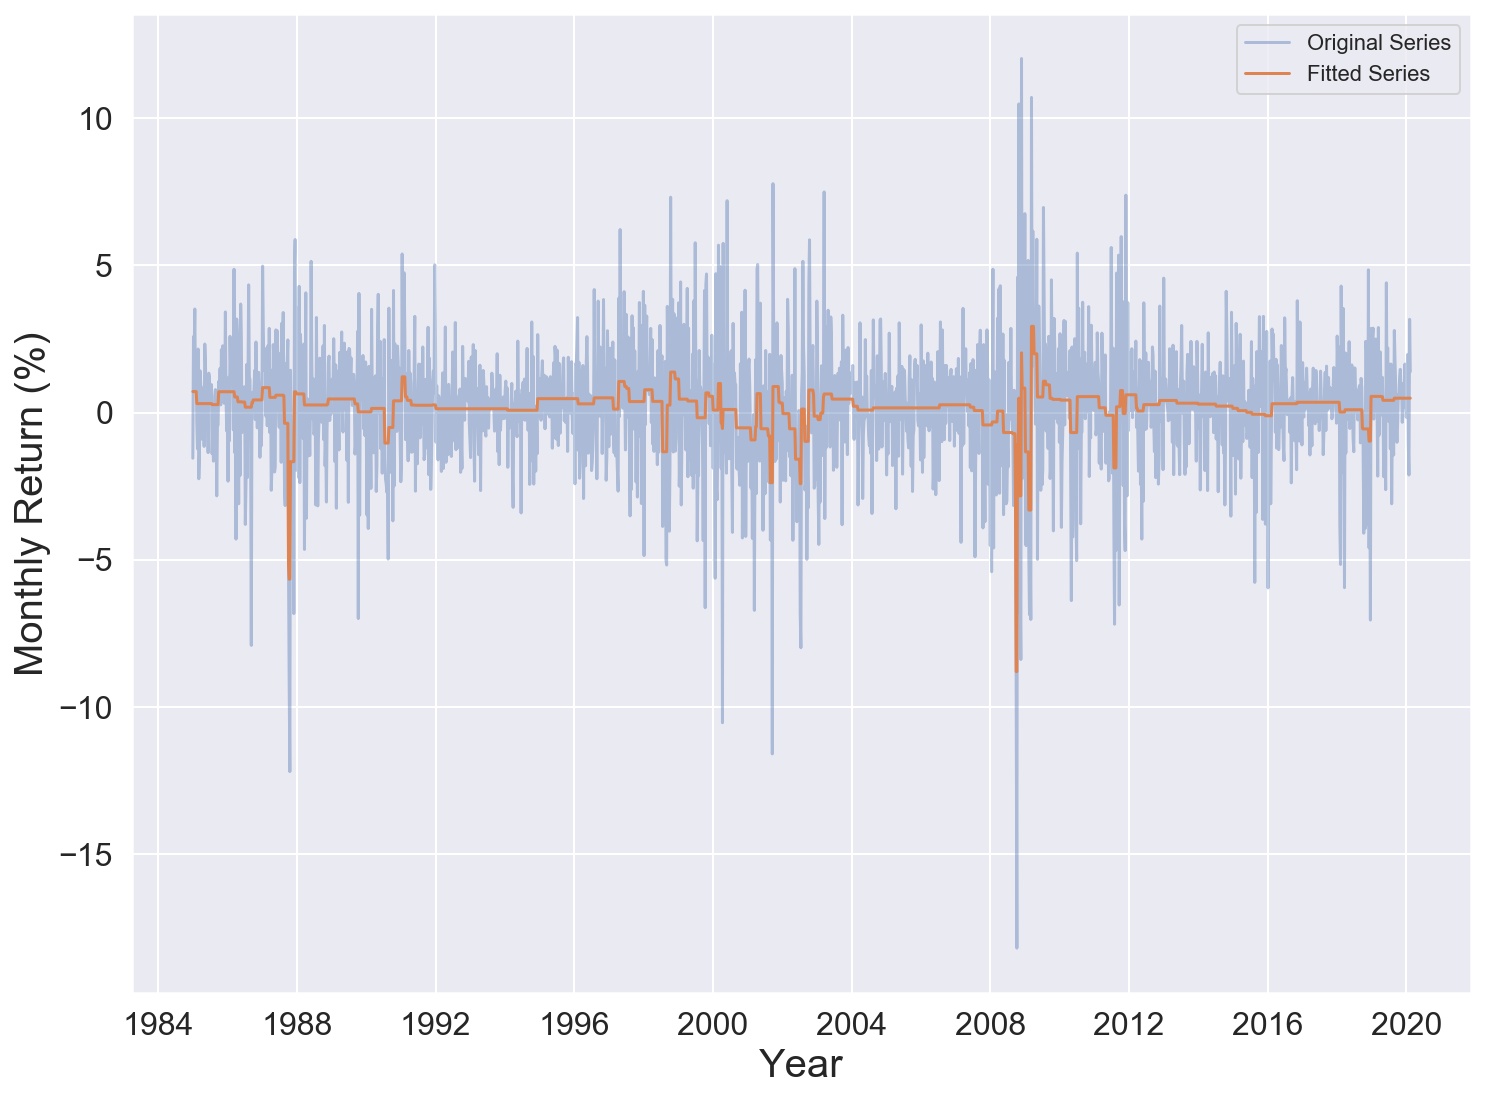

<Figure size 1080x360 with 0 Axes>

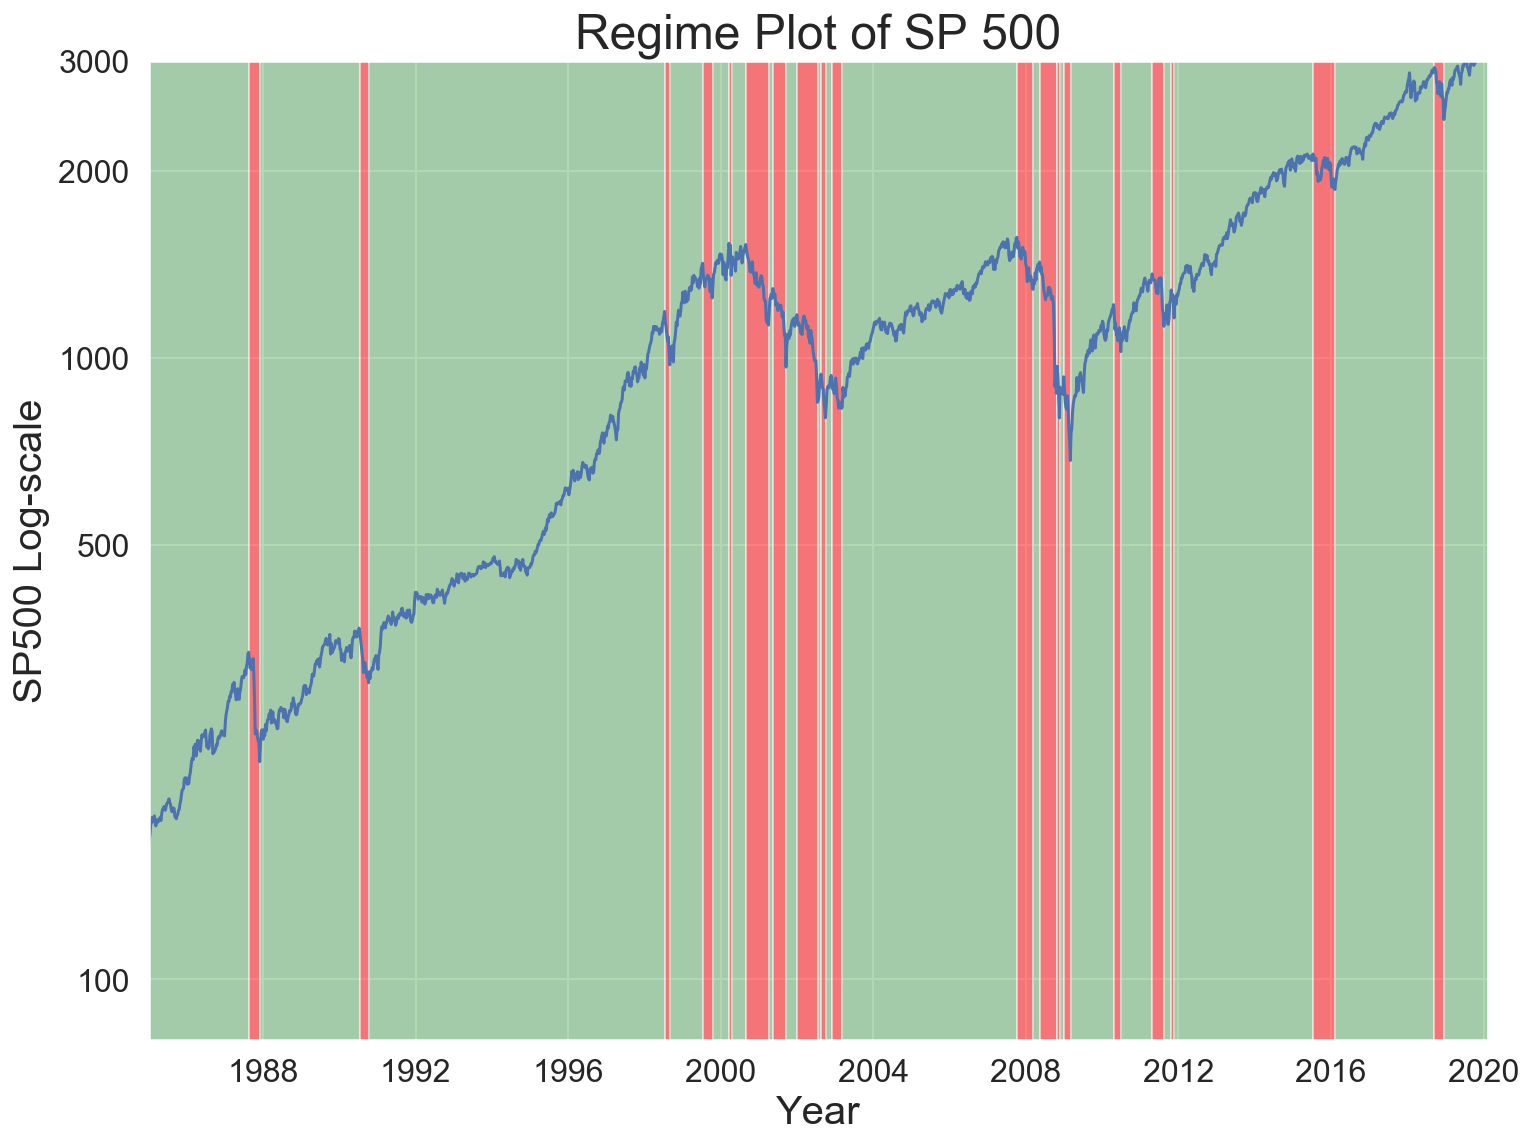

Indexes of regime changes [0, 138, 153, 289, 302, 707, 714, 759, 772, 795, 798, 818, 849, 855, 873, 888, 916, 921, 927, 935, 949, 1189, 1211, 1220, 1243, 1244, 1247, 1253, 1262, 1321, 1331, 1374, 1390, 1400, 1404, 1594, 1624, 1760, 1773, 1833]


DatetimeIndex(['1987-08-24', '1987-12-07', '1990-07-16', '1990-10-15',
               '1998-07-20', '1998-09-07', '1999-07-19', '1999-10-18',
               '2000-03-27', '2000-04-17', '2000-09-04', '2001-04-09',
               '2001-05-21', '2001-09-24', '2002-01-07', '2002-07-22',
               '2002-08-26', '2002-10-07', '2002-12-02', '2003-03-10',
               '2007-10-15', '2008-03-17', '2008-05-19', '2008-10-27',
               '2008-11-03', '2008-11-24', '2009-01-05', '2009-03-09',
               '2010-04-26', '2010-07-05', '2011-05-02', '2011-08-22',
               '2011-10-31', '2011-11-28', '2015-07-20', '2016-02-15',
               '2018-09-24', '2018-12-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [94]:
betas_week = rg.filter_plot(SP500_data_week, lambda_value=10, regime_num=6, TR_num=4)
plt.figure(figsize=(15,5))
rg.plot_regime_color(SP500_data_week, lambda_value=10, regime_num=6, TR_num=4)
switches_week=rg.regime_switch(betas_week)
print('Indexes of regime changes', switches_week)
periods_week = SP500_data_week.index[switches_week[1:-1]]
periods_week


In [95]:
# lambda = 10 catches a lot of the market trembling leading up to 2000 bubble popping (like Long Term cap management 
# in 1998); the market is very calm now, so there is no indication of any trouble right now (2020); market 
# expect smooth sailing

## 3. A Regime-based Single Period Model <a class="anchor" id="3"></a>
Here we will deal with the simplest model: we have stocks, bonds and cash.  We may not be able to run everything until we can "import cvxpy as cp", which is not included in Anaconda 

### 3.1 Regime Identification with the Trend-Filtering Algorithm <a class="anchor" id="3.1"></a>

We have done trend-filtering algorithm in the previous section. Now let's just take the regime from the dataset (column "Regime-5").

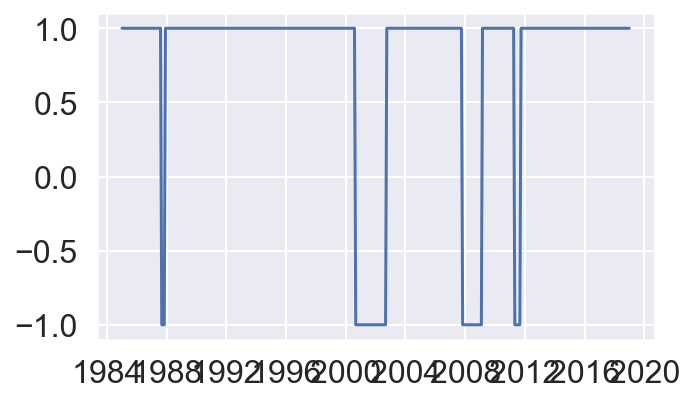

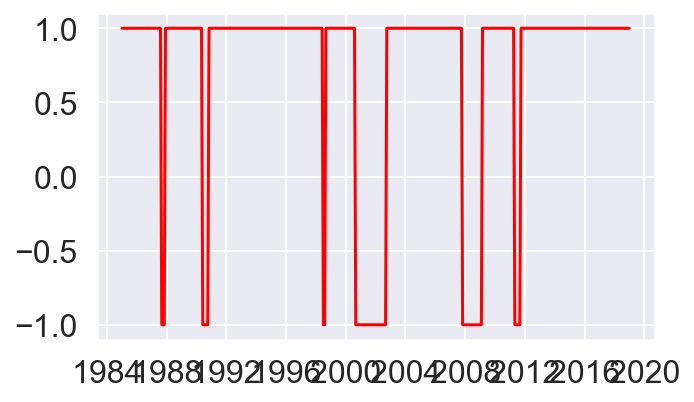

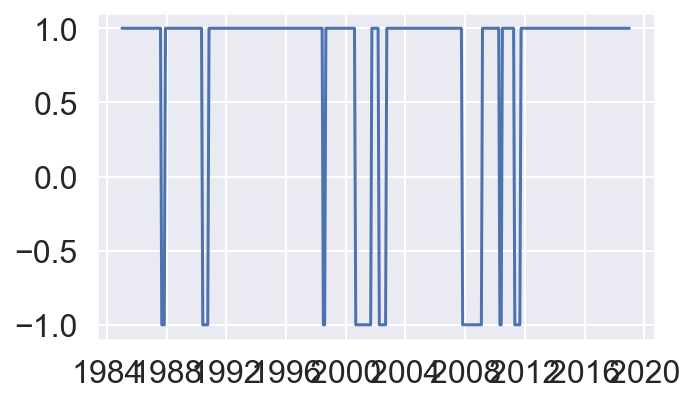

In [57]:
## We can see why Regime-5 chosen - it is the least noisy Regime column 
plt.figure(figsize=(5,3))
plt.plot(asset_data['Regime-5'])
plt.show()

plt.figure(figsize=(5,3))
plt.plot(asset_data['Regime-7'], color='red')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(asset_data['Regime-9'])
plt.show()


### 3.2 Parameter Estimation and Simulation <a class="anchor" id="3.2"></a>



In [59]:
# Set Parameters
n_scen = 10000
m_freq = 12
r_bar = np.arange(0.035,0.115,0.005) # Range of expected returns
len(r_bar)

16

In [62]:
Q_all = np.cov(ret.T) * m_freq             # shape 8x8 ; annual variance = 12* monthly variance; sdev_annual = sqrt(12)*sdev_monthly
r_annual = (1+rg.geo_return(ret)) ** m_freq - 1    # this is the average annualized return over the whole period,  
r_annual = r_annual.reshape(-1,1)               # grossed up from monthly average

r_1 = (1+rg.geo_return(ret)) ** m_freq - 1        # these are annualized, because the geo_return function returns geom average over 
r_g = (1+rg.geo_return(ret_g)) ** m_freq - 1 # entire period; r_1 should equal r_annual, formatted differently though
r_c = (1+rg.geo_return(ret_c)) ** m_freq - 1
n_g = int(n_scen*ret_g.shape[0] / ret.shape[0])
Q_g = np.cov(ret_g.T) * m_freq
Q_c = np.cov(ret_c.T) * m_freq
asset_names =asset_data.columns[0:8]

In [63]:
len(asset_names)

8

In [64]:
print('Q_all', Q_all.shape)
print('r_annual', r_annual.shape)
print('ret', ret.shape)
print('r_l', r_1)
print('r_annual',r_annual)
print('n_g =',n_g)
print('ret_g.shape[0]', ret_g.shape[0])
print('ret.shape[0]',ret.shape[0])

Q_all (8, 8)
r_annual (8, 1)
ret (408, 8)
r_l [0.11412566 0.08932411 0.06335712 0.08898183 0.0918569  0.04002654
 0.074893   0.03426232]
r_annual [[0.11412566]
 [0.08932411]
 [0.06335712]
 [0.08898183]
 [0.0918569 ]
 [0.04002654]
 [0.074893  ]
 [0.03426232]]
n_g = 8799
ret_g.shape[0] 359
ret.shape[0] 408


In [83]:
# Scenario Equivalent version
r_all_1 = np.random.multivariate_normal(r_1, Q_all, n_scen)
print(r_all_1.shape)
Q_1 = np.cov(r_all_1.T)
Q_1.shape

(10000, 8)


(8, 8)

In [78]:
print(r_annual.shape)
print(r_annual.reshape(r_annual.size).shape)

(8, 1)
(8,)


### 3.3 Single-period Portfolio Model <a class="anchor" id="3.3"></a>


    US Equities  World Equities  US Treasuries  High Yield  Real Estate  \
0        -0.000            -0.0          0.002       0.011        0.002   
1         0.006            -0.0          0.082       0.052       -0.000   
2         0.016            -0.0          0.163       0.086       -0.000   
3         0.026            -0.0          0.244       0.120       -0.000   
4         0.035             0.0          0.325       0.154        0.000   
5         0.045             0.0          0.406       0.189        0.000   
6         0.055             0.0          0.487       0.223        0.000   
7         0.064             0.0          0.568       0.257        0.000   
8         0.081            -0.0          0.625       0.295        0.000   
9         0.138            -0.0          0.372       0.284       -0.000   
10        0.191             0.0          0.079       0.250        0.000   
11        0.283            -0.0         -0.000       0.285        0.000   
12        0.389          

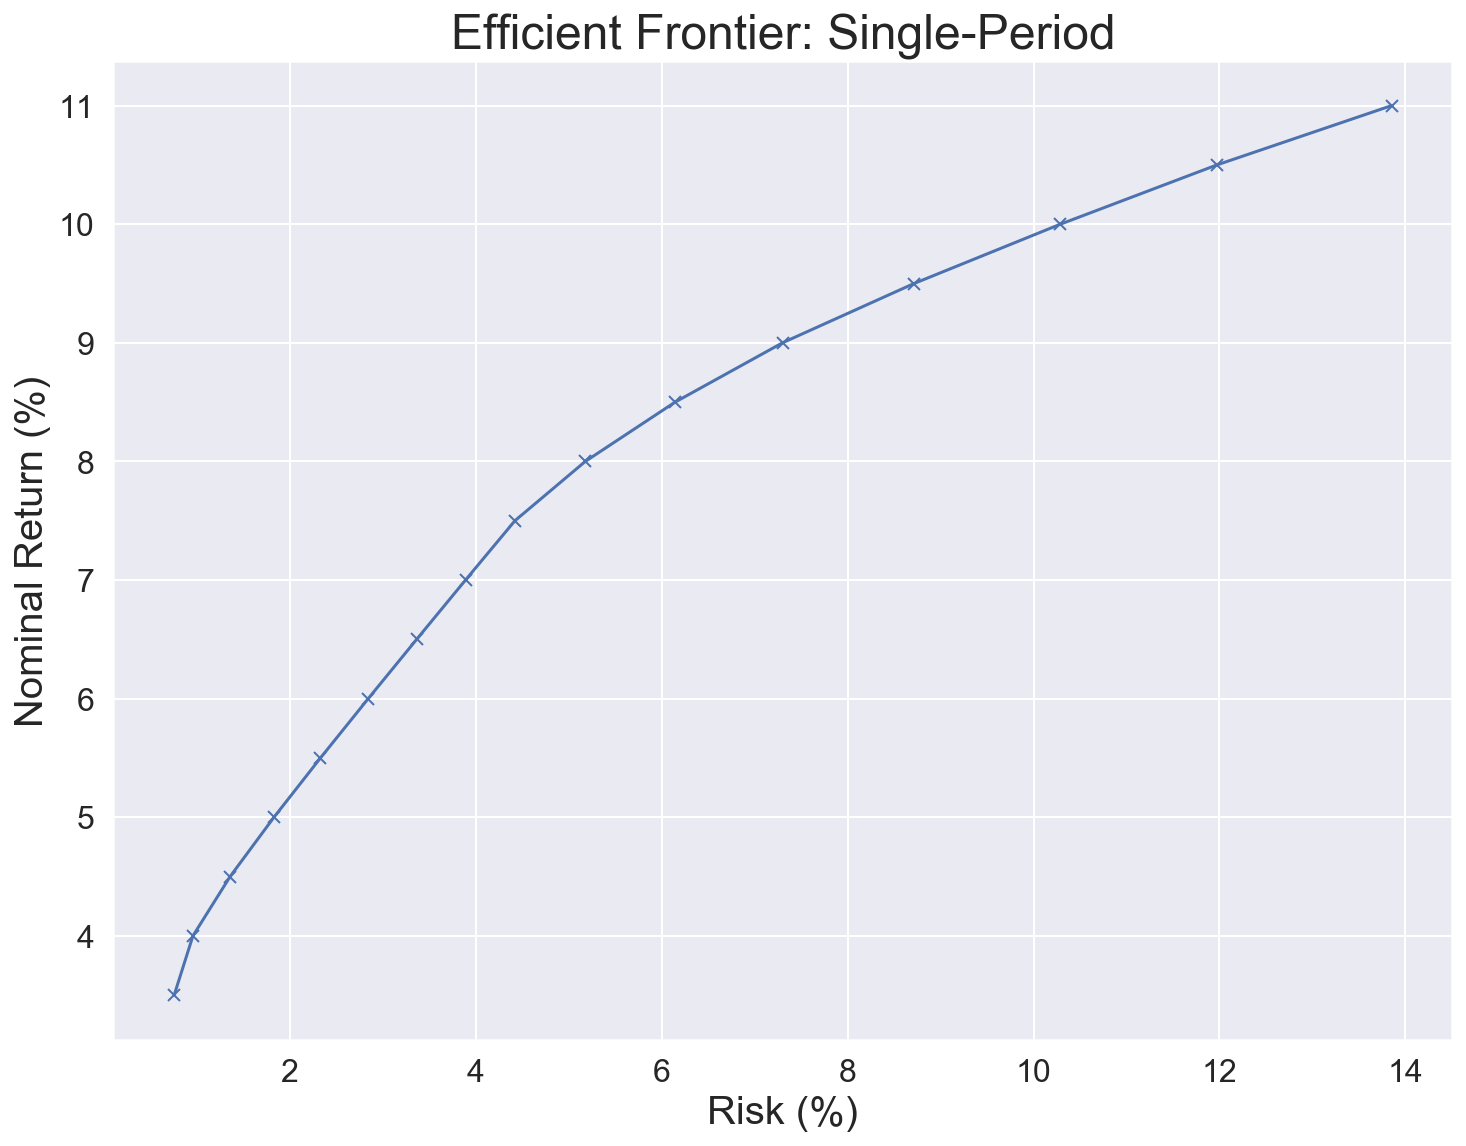

In [66]:
rg.efficient_frontier_traditional(r_annual, Q_all, r_bar, asset_names)

# interesting that world equities are not in the efficient portfolio anywhere; high yield and US equities are where return is
# for low risk, US treasuries and t-bill are in eff. portfolio

Mean returns from 10000  samples is  [0.1145 0.0889 0.0623 0.0894 0.0901 0.0426 0.0742 0.0343]
Means calculated from historical  [0.1141 0.0893 0.0634 0.089  0.0919 0.04   0.0749 0.0343]


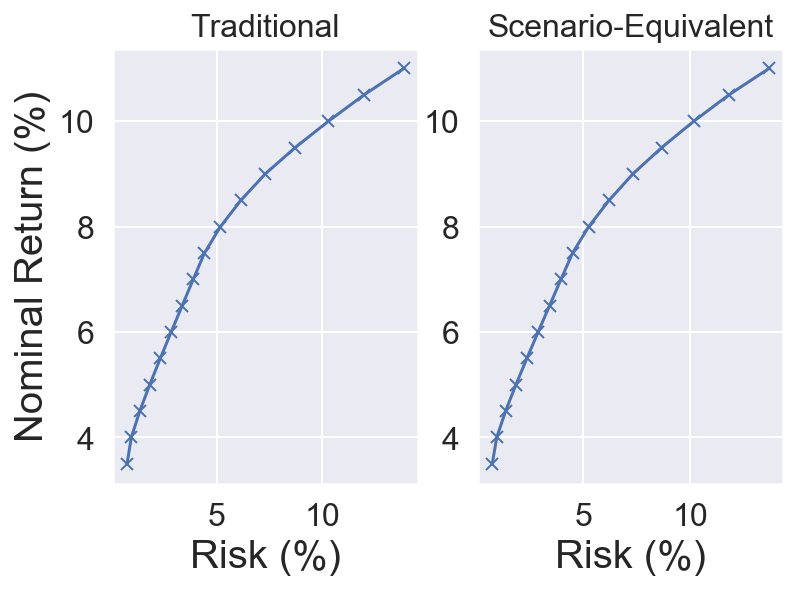

In [89]:
# Compare with scenario equivalent
rg.efficient_frontier_comparison(r_annual, Q_all, r_bar)

### 3.4 Two-regime Simulation

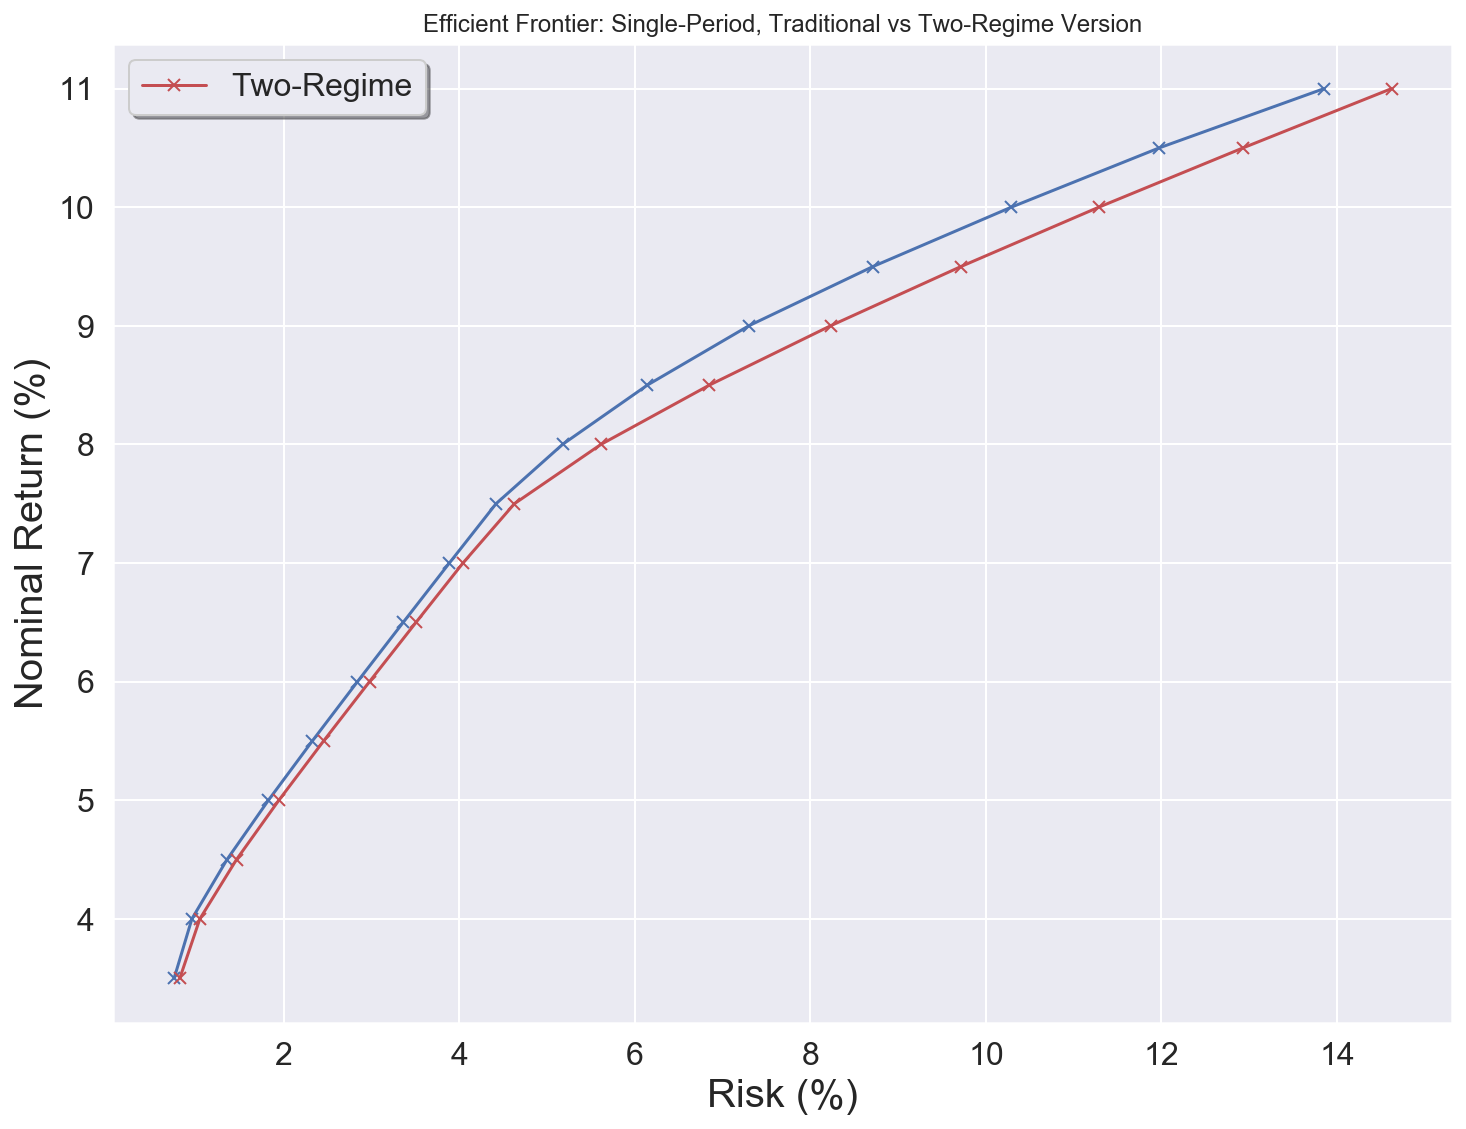

In [94]:
r_all_2 = rg.efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar, asset_names)

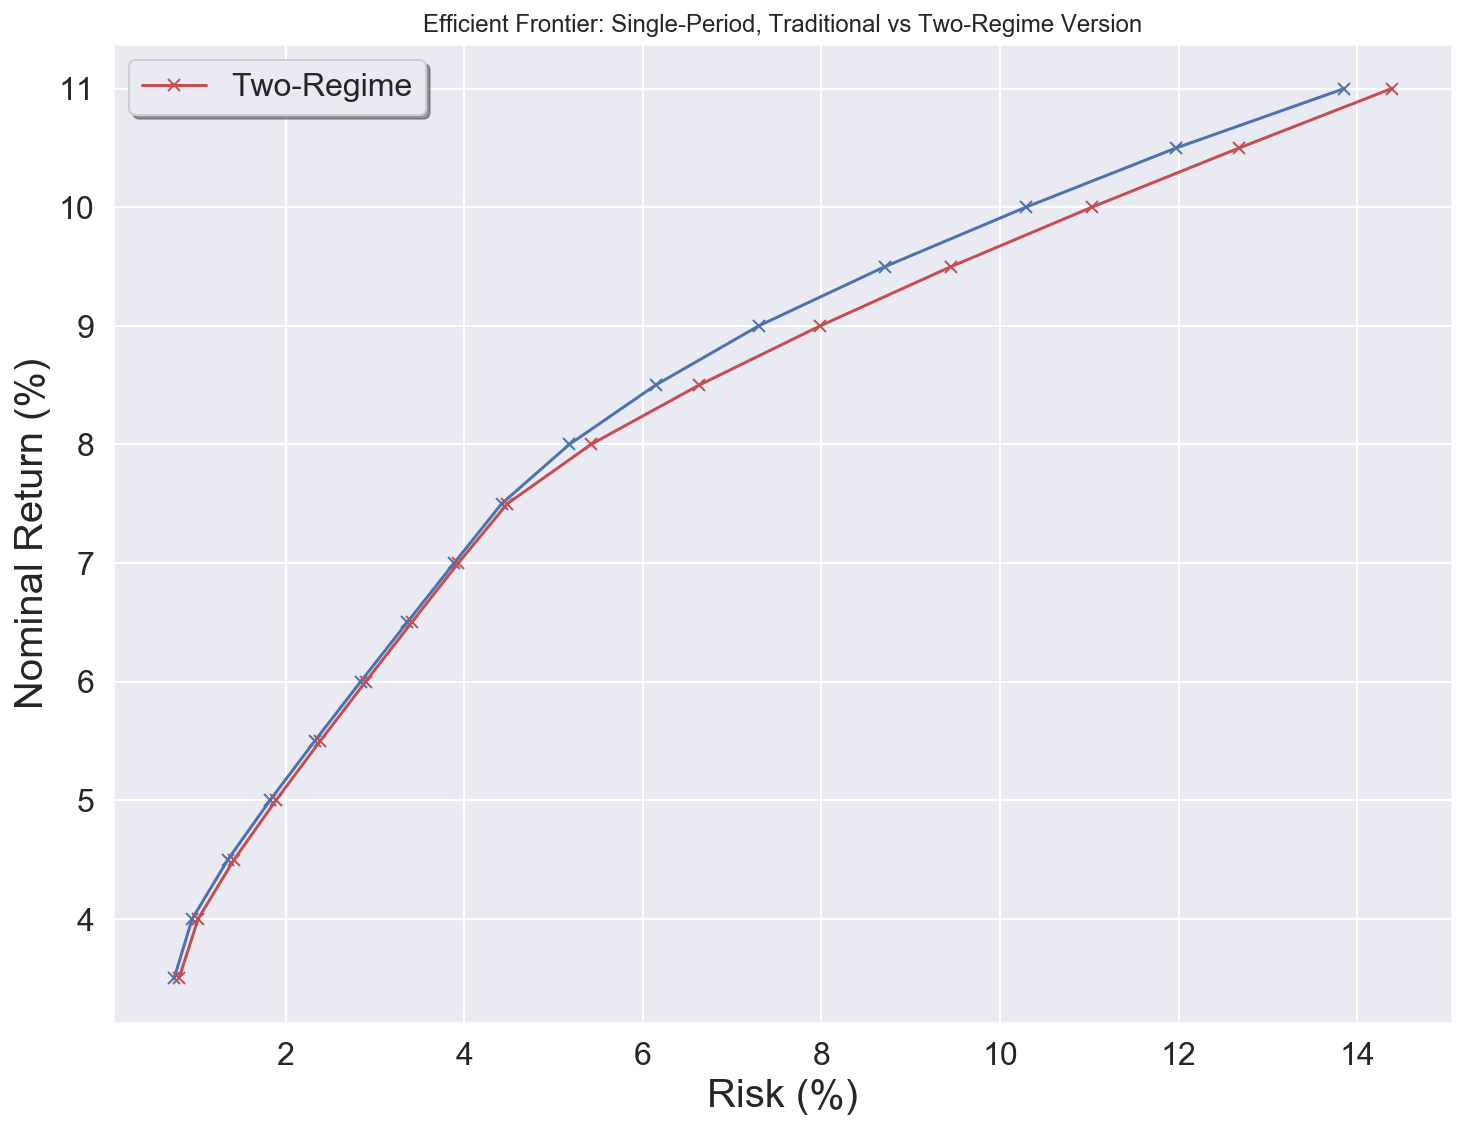

In [100]:
# we can see that red curve varies from one random number generation to another, but teh blue line
# or single period frontier is always the same
r_all_2 = rg.efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar, asset_names)

## 4. Application: Scenario-based Analysis of University Endowment <a class="anchor" id="4"></a>

In [24]:
r_all_50 = asset_simulation(asset_data, asset_num=8, regime_name='Regime-5', random_seed=7, n_scenarios=n_scen)
np.mean(np.mean(r_all_50, axis=0), axis=1)

array([1.00924363, 1.00731724, 1.00513161, 1.00718049, 1.00747885,
       1.0033481 , 1.0060505 , 1.00281213])

In [25]:
holdings = np.array([.3, 0, .2, .2, .1, 0, .15, .05])
result_temp = fund_simulation(holdings, r_all_50, spending_rate=0.07)


In [26]:
# Median Capital after 50 years
# result_temp is a n_scenarios x n_years array of wealth_path, so each column is end of consecutive year's wealth
# and 50th column will be result after final year
# thus, taking median of all rows in 50th column will be the median result over n_scenarios after 50 years

np.median(result_temp[:,-1])


1.9411236102912488